In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import branca
import folium
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

In [3]:
# Full database
# df is still the sample csv, need to be changed with the full dataset filtered on stations from Rotterdam to the Hague
df = pd.read_csv('data/complete_dataset_clean_vf.csv', sep=";") 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")

#df["UITVOERTIJD_VERTREK"] = pd.to_timedelta(df["UITVOERTIJD_VERTREK"].str.split('.').str[0])
#df['PLANTIJD_VERTREK'] = pd.to_timedelta(df['PLANTIJD_VERTREK'].str.split('.').str[0])
#df['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df['UITVOERTIJD_AANKOMST'].str.split('.').str[0])
    
#Small database for testing
#df= df.head(100)
display (df)

,DAGNR,WEEK_DAG_NR,TRAJECT,DAGDEELTREIN,TREINSERIEBASIS,PLANTIJD_VERTREK,UITVOERTIJD_AANKOMST,UITVOERTIJD_VERTREK,BEWEGINGNUMMER,REALISATIE,...,Storms_flag,Warm_flag,Cold_flag,Sunny_flag,disrupt_any,disrupt_signal,disrupt_track,disrupt_power,Previous train canceled,Previous train delayed
0,1,6,Dt_Dtcp,Weekend,5100.0,00:10:00.000,00:14:07.000,2025-10-20 00:12:16,5193,404.859094,...,0,0,0,0,0,0,0,0,0,0
1,1,6,Dt_Dtcp,Weekend,5100.0,00:40:00.000,00:48:34.000,2025-10-20 00:46:36,5195,752.614682,...,0,0,0,0,0,0,0,0,0,2
2,1,6,Dt_Dtcp,Weekend,5100.0,05:10:00.000,05:12:14.000,2025-10-20 05:10:18,5117,109.815924,...,0,0,1,0,0,0,0,0,0,6
3,1,6,Dt_Dtcp,Weekend,5100.0,06:10:00.000,06:14:19.000,2025-10-20 06:11:54,5121,58.159644,...,0,0,1,0,0,0,0,0,0,0
4,1,6,Dt_Dtcp,Weekend,5100.0,06:40:00.000,06:42:47.000,2025-10-20 06:40:56,5123,42.627936,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98612,30,7,Vst_Gvm,Weekend,4600.0,22:57:00.000,23:01:39.000,2025-10-20 22:57:34,4674,99.864740,...,0,0,1,0,0,0,0,0,0,0
98613,30,7,Vst_Gvm,Weekend,4600.0,23:27:00.000,23:31:46.000,2025-10-20 23:27:41,4676,68.612430,...,0,0,1,0,0,0,0,0,0,0
98614,30,7,Vst_Gvm,Weekend,4600.0,23:57:00.000,00:01:50.000,2025-10-20 23:57:50,4678,80.157066,...,0,0,1,0,0,0,0,0,0,0
98615,30,7,Vst_Gvm,Unknown,Unknown,NaN,01:01:32.000,2025-10-20 00:57:29,4682,27.707867,...,0,0,0,0,0,0,0,0,0,0


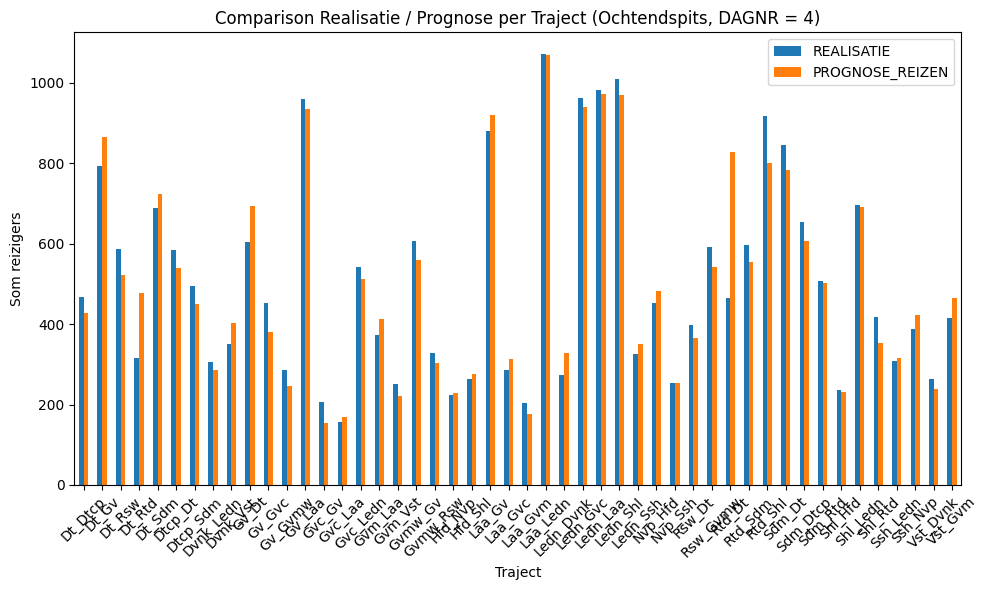

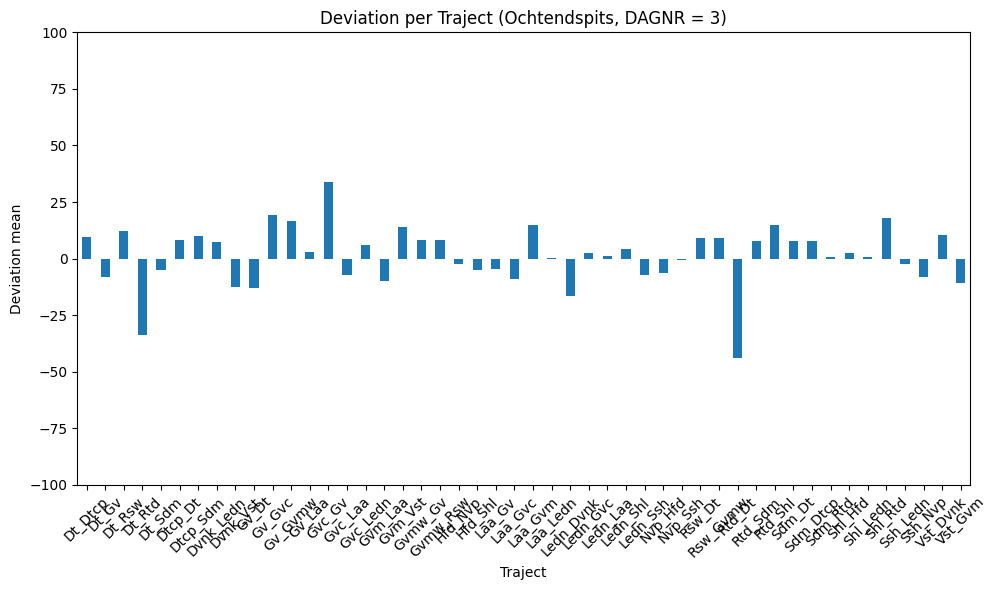

In [4]:

df_dag3 = df[(df["DAGDEELTREIN"] == "Ochtendspits") & (df["DAGNR"] == 4) & (df["Cancelled"] == False) ]

traject_df = (df_dag3.groupby("TRAJECT", as_index=True)[["REALISATIE", "PROGNOSE_REIZEN"]].mean())

traject_df["AFWIJKING"] = ((traject_df["REALISATIE"] - traject_df["PROGNOSE_REIZEN"])/ traject_df["PROGNOSE_REIZEN"]) * 100

traject_df[["REALISATIE", "PROGNOSE_REIZEN"]].plot(kind="bar", figsize=(10,6))

plt.title("Comparison Realisatie / Prognose per Traject (Ochtendspits, DAGNR = 4)")
plt.xlabel("Traject")
plt.ylabel("Som reizigers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

traject_df["AFWIJKING"].plot(kind="bar", figsize=(10,6))
plt.title("Deviation per Traject (Ochtendspits, DAGNR = 3)")
plt.xlabel("Traject")
plt.ylabel("Deviation mean")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(-100, 100)
plt.show()



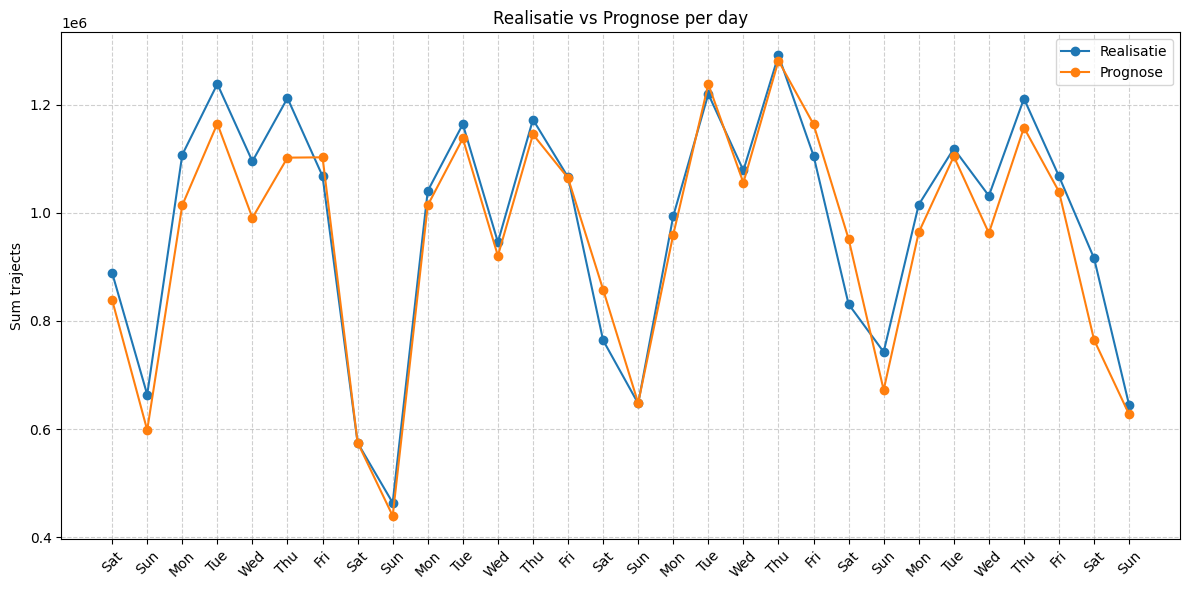

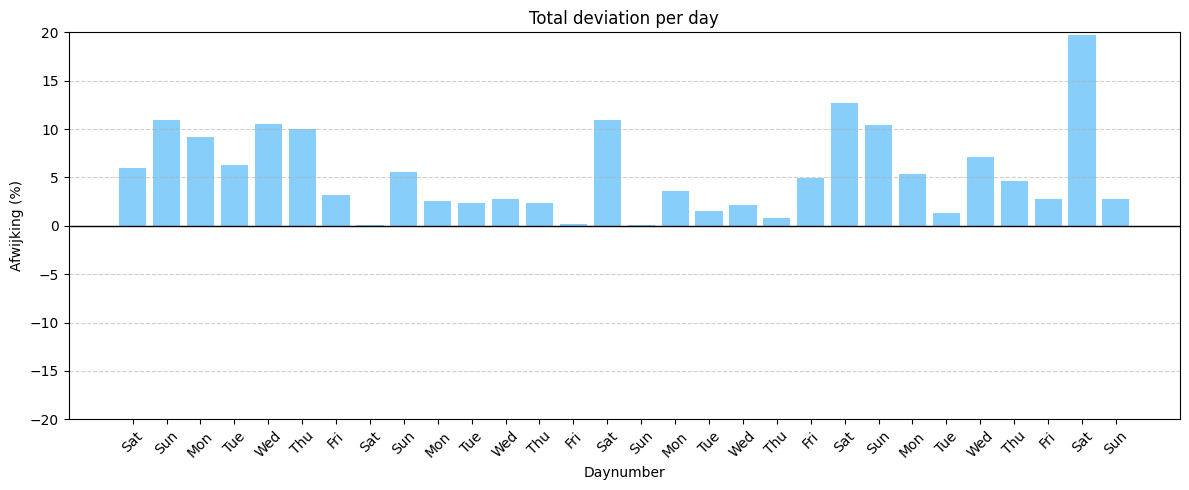

Absolute gemiddelde afwijking: 5.43%


In [40]:
df_filtered = df
dag_totaal = (df_filtered.groupby("DAGNR")[["REALISATIE", "PROGNOSE_REIZEN"]].sum())
dag_totaal["AFWIJKING_%"] = ((dag_totaal["REALISATIE"] - dag_totaal["PROGNOSE_REIZEN"])/ dag_totaal["PROGNOSE_REIZEN"]) * 100

dag_totaal_afwijking = dag_totaal["AFWIJKING_%"].abs()

days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]

day_labels = [days[(d - 1) % 7] for d in dag_totaal.index]

plt.figure(figsize=(12,6))
plt.plot(dag_totaal.index, dag_totaal["REALISATIE"], label="Realisatie", marker="o")
plt.plot(dag_totaal.index, dag_totaal["PROGNOSE_REIZEN"], label="Prognose", marker="o")
plt.title("Realisatie vs Prognose per day")
plt.xticks(dag_totaal.index, day_labels, rotation=45)
plt.ylabel("Sum trajects")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.bar(dag_totaal.index, dag_totaal_afwijking, color="lightskyblue")
plt.title("Total deviation per day")
plt.xlabel("Daynumber")
plt.xticks(dag_totaal.index, day_labels, rotation=45)
plt.ylabel("Afwijking (%)")
plt.ylim(-20, 20)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Deviation = dag_totaal_afwijking.abs().mean()
print(f"Absolute gemiddelde afwijking: {Deviation:.2f}%")

#display (dag_totaal)

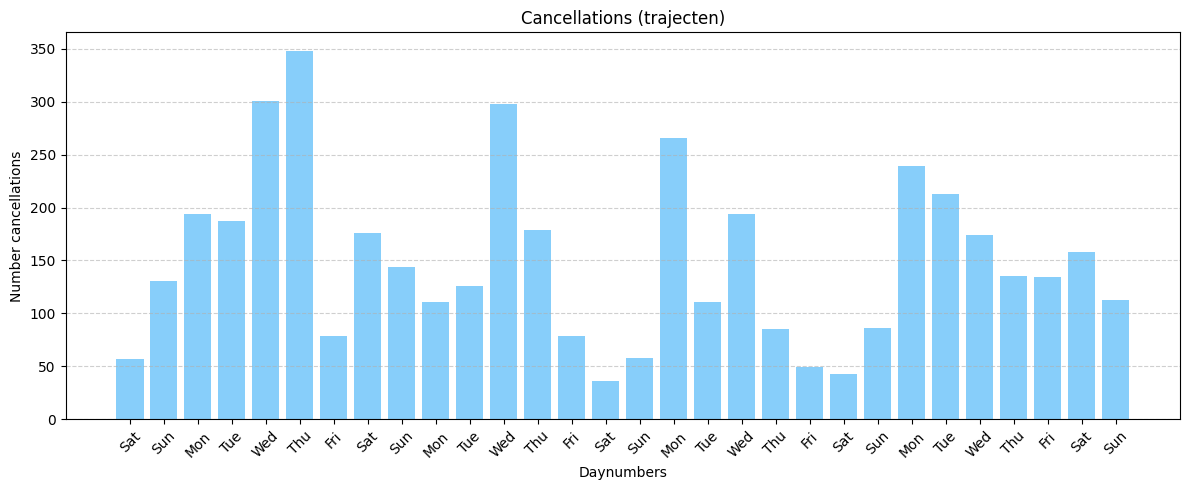

In [44]:
df_cancel = df

# 🔹 Tel aantal geannuleerde ritten per dag
cancellations_per_day = (df_cancel[df_cancel["Previous train canceled"] == 1].groupby("DAGNR").size().reindex(range(1, 32)))


plt.figure(figsize=(12,5))
plt.bar(cancellations_per_day.index, cancellations_per_day.values, color="lightskyblue")
plt.title("Cancellations (trajecten)")
plt.xticks(dag_totaal.index, day_labels, rotation=45)
plt.xlabel("Daynumbers")
plt.ylabel("Number cancellations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



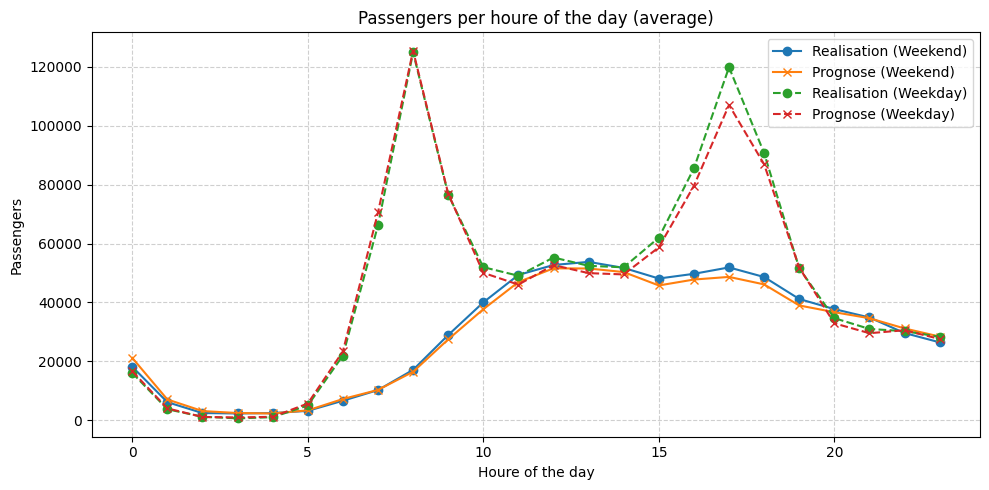

In [23]:
df_filtered = df.copy()

if not pd.api.types.is_timedelta64_dtype(df_filtered['UITVOERTIJD_AANKOMST']):
    df_filtered['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df_filtered['UITVOERTIJD_AANKOMST'])
df_filtered['UUR'] = df_filtered['UITVOERTIJD_AANKOMST'].dt.seconds // 3600

df_filtered['DAGTYPE'] = df_filtered['DAGNR'] % 7
df_filtered['IS_WEEKEND'] = df_filtered['DAGTYPE'].isin([1, 2])

weekend = df_filtered[df_filtered['IS_WEEKEND']]
weekday = df_filtered[~df_filtered['IS_WEEKEND']]

n_weekend_days = weekend['DAGNR'].nunique()
n_weekday_days = weekday['DAGNR'].nunique()

weekend_sum = weekend.groupby('UUR')[['REALISATIE', 'PROGNOSE_REIZEN']].sum() / n_weekend_days
weekday_sum = weekday.groupby('UUR')[['REALISATIE', 'PROGNOSE_REIZEN']].sum() / n_weekday_days


plt.figure(figsize=(10,5))
plt.plot(weekend_sum.index, weekend_sum['REALISATIE'], label='Realisation (Weekend)', linestyle='-', marker='o')
plt.plot(weekend_sum.index, weekend_sum['PROGNOSE_REIZEN'], label='Prognose (Weekend)', linestyle='-', marker='x')

plt.plot(weekday_sum.index, weekday_sum['REALISATIE'], label='Realisation (Weekday)', linestyle='--', marker='o')
plt.plot(weekday_sum.index, weekday_sum['PROGNOSE_REIZEN'], label='Prognose (Weekday)', linestyle='--', marker='x')

plt.title('Passengers per houre of the day (average)')
plt.xlabel('Houre of the day')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




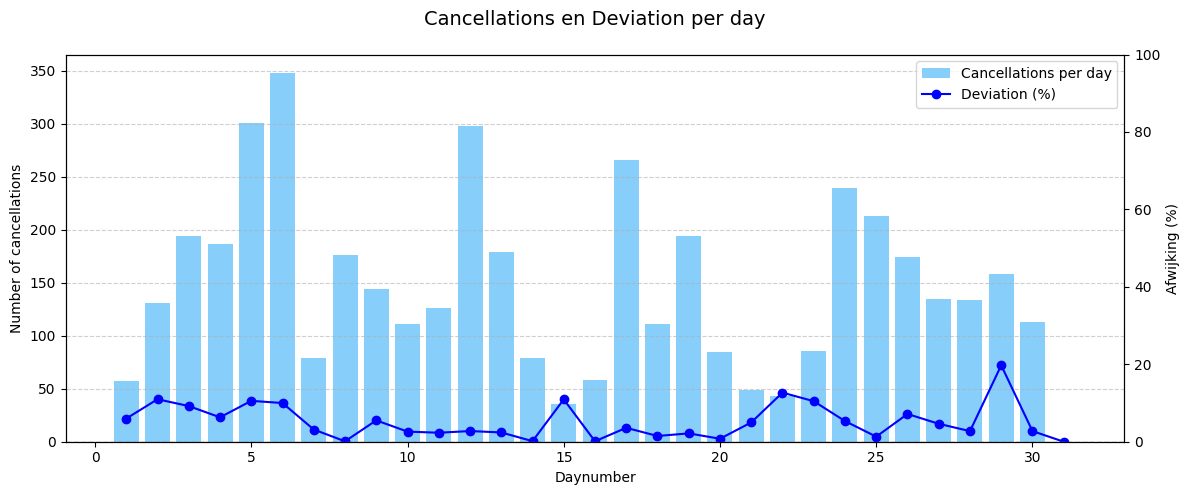

In [42]:
dag_totaal_afwijking_graph = dag_totaal_afwijking

df_cancel = dfcancellations_per_day = (df_cancel[df_cancel["Cancelled"] == True].groupby("DAGNR").size().reindex(range(1, 32), fill_value=0))

combined = pd.DataFrame({"CANCELLATIONS": cancellations_per_day,"AFWIJKING_%": dag_totaal_afwijking_graph}).fillna(0)
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.bar(combined.index, combined["CANCELLATIONS"], color="lightskyblue", label="Cancellations per day")
ax1.set_xlabel("Daynumber")
ax1.set_ylabel("Number of cancellations")
ax1.tick_params(axis='y')
ax1.grid(axis="y", linestyle="--", alpha=0.6)


ax2 = ax1.twinx()
ax2.plot(combined.index, combined["AFWIJKING_%"], color="blue", marker="o", label="Deviation (%)")
ax2.set_ylabel("Afwijking (%)")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)
ax2.axhline(0, color='gray', linewidth=1, linestyle="--")


fig.suptitle("Cancellations en Deviation per day", fontsize=14)
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()



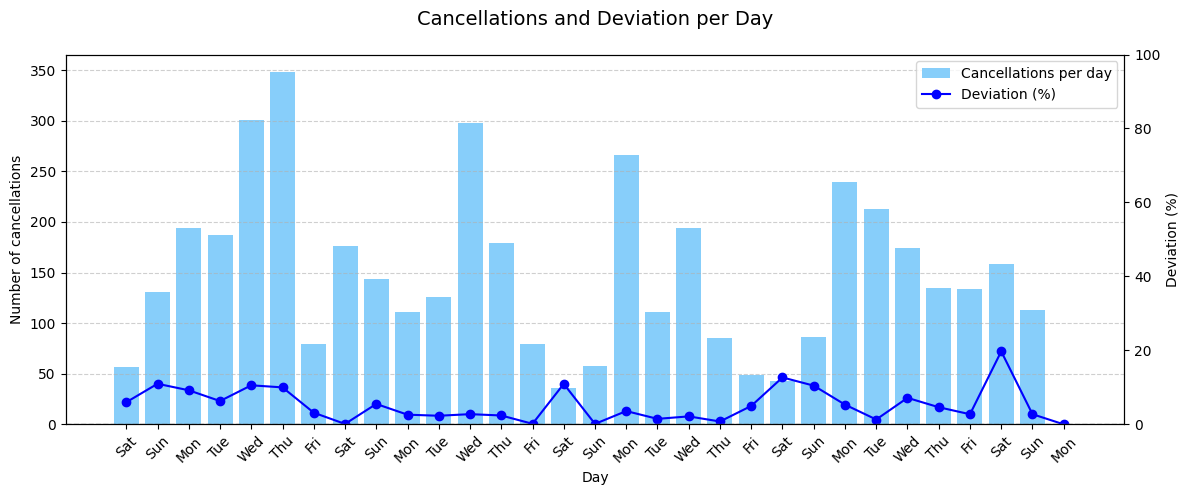

In [45]:
dag_totaal_afwijking_graph = dag_totaal_afwijking
df_cancellations_per_day = ( df_cancel[df_cancel["Previous train canceled"] == True] .groupby("DAGNR") .size() .reindex(range(1, 32), fill_value=0))

days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]
day_labels = [days[(d - 1) % 7] for d in range(1, 32)]

combined = pd.DataFrame({"CANCELLATIONS": df_cancellations_per_day, "AFWIJKING_%": dag_totaal_afwijking_graph}).fillna(0)
fig, ax1 = plt.subplots(figsize=(12, 5))


ax1.bar(combined.index, combined["CANCELLATIONS"], color="lightskyblue", label="Cancellations per day")
ax1.set_xlabel("Day")
ax1.set_ylabel("Number of cancellations")
ax1.tick_params(axis='y')
ax1.grid(axis="y", linestyle="--", alpha=0.6)

ax1.set_xticks(combined.index)
ax1.set_xticklabels(day_labels, rotation=45)

ax2 = ax1.twinx()
ax2.plot(combined.index, combined["AFWIJKING_%"], color="blue", marker="o", label="Deviation (%)")
ax2.set_ylabel("Deviation (%)")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)
ax2.axhline(0, color='gray', linewidth=1, linestyle="--")

fig.suptitle("Cancellations and Deviation per Day", fontsize=14)
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()


In [ ]:
df2 = pd.read_csv("data/Train_distances.csv")

df2.head()

stations = [
    "Dvnk", "Dt", "Dtcp", "Gvc", "Gv", "Laa", "Gvm", "Gvmw", 
    "Hfd", "Ledn", "Nvp", "Rsw", "Rtd", "Ssh", "Sdm", "Shl", "Vst"
]

stations_lower = [s.lower() for s in stations]
df2.columns = [c.lower()for c in df2.columns]

df2["station"] = df2["station"].str.lower()
df2_filtered = df2[df2["station"].isin(stations_lower)]

cols_to_keep = ["station"] + [c for c in df2.columns if c in stations_lower]
df2_filtered = df2_filtered[cols_to_keep]

df2_filtered = df2_filtered.reset_index(drop=True)

display(df2_filtered)


,station,dt,dtcp,dvnk,gv,gvc,gvm,gvmw,hfd,laa,ledn,nvp,rsw,rtd,sdm,shl,ssh,vst
0,dt,XXX,1,21,8,9,13,7,48,10,24,43,5,14,10,53,32,19
1,dtcp,1,XXX,22,9,10,14,8,49,11,25,44,6,13,9,54,33,20
2,dvnk,21,22,XXX,13,12,8,14,27,11,3,22,16,35,31,32,11,2
3,gv,8,9,13,XXX,1,5,1,40,2,16,35,3,22,18,45,24,11
4,gvc,9,10,12,1,XXX,4,2,39,1,15,34,4,23,19,44,23,10
5,gvm,13,14,8,5,4,XXX,6,35,3,11,30,8,27,23,40,19,6
6,gvmw,7,8,14,1,2,6,XXX,41,3,17,36,2,21,17,46,25,12
7,hfd,48,49,27,40,39,35,41,XXX,38,24,5,43,62,58,5,16,29
8,laa,10,11,11,2,1,3,3,38,XXX,14,33,5,24,20,43,22,9
9,ledn,24,25,3,16,15,11,17,24,14,XXX,19,19,38,34,29,8,5


In [ ]:
import pandas as pd

distances = df2_filtered.set_index("station")
trips = pd.read_csv("data/data_NS_filtered.csv", sep=";")

trips = trips[trips["DAGNR"] == 2]

trips["station1"] = trips["station1"].str.lower()
trips["station2"] = trips["station2"].str.lower()

def get_distance(row):
    s1, s2 = row["station1"], row["station2"]
    try:
        val = distances.loc[s1, s2]
    except KeyError:
        return None
    if val == "XXX":
        return 0
    return float(val)

trips["afstand_km"] = trips.apply(get_distance, axis=1)

trips["passagiers_km"] = trips["REALISATIE"] * trips["afstand_km"]

trips["passagiers_km"] = trips["passagiers_km"].round(2)

display(trips[["station1", "station2", "REALISATIE",  "afstand_km", "passagiers_km",]])

print("Totale afstand (km):", trips["afstand_km"].sum())
print("Totale passagiers-km:", trips["passagiers_km"].sum())




,station1,station2,REALISATIE,afstand_km,passagiers_km
2706,shl,ledn,59.126592,29.0,1714.67
2707,ledn,gvc,20.603867,15.0,309.06
2708,shl,ledn,121.143386,29.0,3513.16
2709,ledn,gvc,100.890603,15.0,1513.36
2710,shl,ledn,277.063764,29.0,8034.85
...,...,...,...,...,...
5417,laa,gv,404.187090,2.0,808.37
5418,ledn,laa,428.682368,14.0,6001.55
5419,sdm,rtd,317.991531,4.0,1271.97
5420,shl,ledn,383.399712,29.0,11118.59


Totale afstand (km): 30004.0
Totale passagiers-km: 8174592.799999999
